In [1]:
import intel_extension_for_pytorch as ipex
from torchvision.datasets import CIFAR10, CelebA
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch
from tqdm import tqdm
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\hserg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\hserg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\hserg\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trainset = CIFAR10(root='../data', train=True,  transform=transforms.ToTensor(), download=True)
testset  = CIFAR10(root='../data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
BATCH_SIZE = 8
trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True, num_workers=2)

In [4]:
classes = {i:name for i, name in enumerate(trainset.classes)}
classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [5]:
imgs, labels = next(iter(trainloader))

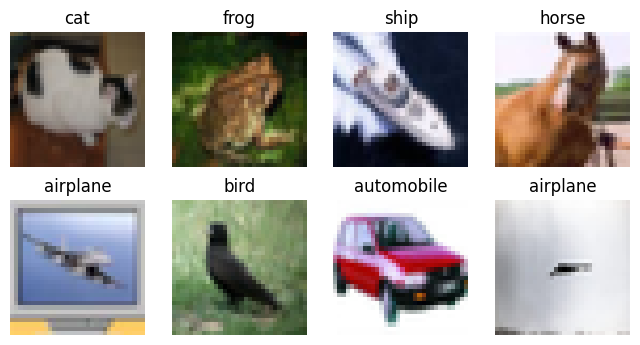

In [6]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1])
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

show_imgs(imgs, labels)

In [37]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            # ConvBlock2 (4x4)
            nn.ConvTranspose2d(in_channels=latent_dim, 
                               out_channels=256,
                               kernel_size=4, 
                               stride=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock3 (8x8)
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128,
                               kernel_size=4, 
                               stride=2, 
                               padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock4 (16x16)
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64,
                               kernel_size=4, 
                               stride=2, 
                               padding=1, bias=False), 
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # Final Conv Transpose (32x32)
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=3,
                               kernel_size=4,
                               stride=2, 
                               padding=1, bias=False))
    
    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)

In [38]:
class Discriminator(nn.Module):
    def __init__(self, n_classes: int, img_shape: Tuple):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=torch.prod(img_shape))
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=6,
                      out_channels=64,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=256, 
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0), 
            nn.Flatten(),
            nn.Sigmoid())
        
    def forward(self, input, labels):
        embds = self.embeddings(labels).view(input.shape)
        concat = torch.cat((input, embds), dim=1)
        return self.model(concat)

In [39]:
class ModelConfig:
    def __init__(self, batch_size, epochs, classes):
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.CLASSES = classes

In [40]:
class CGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(CGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_optimizer, g_loss,
                      d_optimizer, d_loss):
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss 
        self.d_loss = d_loss
    
    def forward(self, labels):
        with torch.inference_mode():
            out = self.generator(labels)
        return out.detach()

In [59]:
def train_step(model: nn.Module, trainloader: DataLoader,
               device: torch.device, metric: callable=None):
    
    tg_loss, td_loss = .0, .0
    for real_imgs, labels in tqdm(trainloader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # setting grads to 0 after last generator backprop
        model.d_optimizer.zero_grad()
        
        # labels for real&fake images
        ones = torch.ones_like(labels).unsqueeze(dim=-1).float()
        zeros = torch.zeros_like(labels).unsqueeze(dim=-1).float()
        
        # generated images conditioned on labels
        fake_imgs = model.generator(labels)
        
        # discriminator output based on fake&real images
        d_fake = model.discriminator(fake_imgs.detach(), labels)
        d_real = model.discriminator(real_imgs, labels)
        
        
        # discriminator loss using real real^fake labels
        d_fake_loss = model.d_loss(d_fake, zeros)
        d_real_loss = model.d_loss(d_real, ones)
        
        d_total_loss = (d_fake_loss + d_real_loss)/2 
        td_loss += d_total_loss.item()

        # discriminator backpropagation
        d_total_loss.backward()
        model.d_optimizer.step()

        # generator backpropagation        
        model.g_optimizer.zero_grad()
        d_fake = model.discriminator(fake_imgs, labels)
        g_loss = model.g_loss(d_fake, ones)
        
        tg_loss += g_loss.item()
        print("Fake Images:", fake_imgs.device)
        print("Ones Tensor:", ones.device)
        print("Discriminator Output:", d_fake.device)
        print("Generator Loss:", g_loss)
        g_loss.backward()
        model.g_optimizer.step()
        break

    # n_batches = len(trainloader)
    # tg_loss, td_loss /= n_batches, n_batches
    # return tg_loss, td_loss
    return tg_loss, td_loss
        
        
def train(model: nn.Module, trainloader: DataLoader,
          testloader: DataLoader, device: torch.device, metric: callable=None):
    model = model.to(device)
    train_step(model, trainloader, device)

LATENT_DIM = 100
device = 'xpu' if ipex.xpu.is_available() else 'cpu'

generator = Generator(LATENT_DIM, len(classes))
discriminator = Discriminator(len(classes), torch.tensor(imgs[0].shape))

g_optimizer = optim.Adam(generator.parameters())
d_optimizer = optim.Adam(discriminator.parameters())

g_loss = nn.BCELoss()
d_loss = nn.BCELoss()

cgan = CGAN(generator, discriminator)
cgan.compile(g_optimizer, g_loss, 
             d_optimizer, d_loss)


train(cgan, trainloader, testloader, device)

  0%|          | 0/6250 [00:00<?, ?it/s]

Fake Images: xpu:0
Ones Tensor: xpu:0
Discriminator Output: xpu:0
Generator Loss: tensor(2.1898, device='xpu:0', grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/6250 [00:03<?, ?it/s]


RuntimeError: Cannot access data pointer of Tensor that doesn't have storage